# MNIST Prediction Using Tensorflow v1.15

In [1]:
import numpy as np
import tensorflow as tf
from dython.model_utils import roc_graph, _ROC_PLOT_COLORS
from tensorflow.examples.tutorials.mnist import input_data

## Hyper-parameters

In [2]:
epochs = 5000
batch_size = 50
learning_rate = 1e-4
dropout_keep_prob = 0.5

## Initialization

In [3]:
tf.reset_default_graph()
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

## Tensorflow Graph
### Decalring Inputs

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lr = tf.placeholder(tf.float32, name='learning_rate')

### Graph Construction
The images are saved as one-dimensional arrays. We'll want to reshape them to two-dimensional arrays in order to feed them into convolution layers. This is performed at the first line below.

The network consists of two blocks of layers made of [Convolution, ReLU, Max Pooling], followed by two dense layers and a dropout betwwen them.

In [5]:
layer = tf.reshape(x, [-1, 28, 28, 1])  # [batch_size, image_height, image_width, color_channels]
layer = tf.nn.conv2d(layer, tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1)),
                     strides=[1, 1, 1, 1], padding='SAME')
layer = tf.nn.relu(layer + tf.Variable(tf.constant(0.1, shape=[32])))
layer = tf.nn.max_pool2d(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
layer = tf.nn.conv2d(layer, tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1)),
                     strides=[1, 1, 1, 1], padding='SAME')
layer = tf.nn.relu(layer + tf.Variable(tf.constant(0.1, shape=[64])))
layer = tf.nn.max_pool2d(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
layer = tf.reshape(layer, [-1, 7*7*64])  # image size is now 7x7 with 64 channels
layer = tf.layers.dense(inputs=layer, units=1024, activation=tf.nn.relu)
layer = tf.nn.dropout(layer, keep_prob)
layer = tf.layers.dense(inputs=layer, units=10)
output = tf.nn.softmax(layer)

### Graph Optimization

In [6]:
cost = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y, logits=layer))
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

### Graph Saver

In [7]:
saver = tf.train.Saver()
filename = 'best_model.ckpt'

## Training

In [8]:
best_acc = 0.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_true = np.argmax(mnist.test.labels, axis=1)
    for i in range(1, epochs+1):
        batch = mnist.train.next_batch(batch_size)
        c, _ = sess.run([cost, optimizer], feed_dict={x: batch[0], y: batch[1],
                                                      lr: learning_rate, keep_prob: dropout_keep_prob})
        if i % 100 == 0 or i == 1:
            y_pred = np.argmax(sess.run(output, feed_dict={x: mnist.test.images, keep_prob: 1.}), axis=1)
            acc = 100 * np.sum(np.equal(y_true, y_pred)) / len(y_true)
            print(f'Epoch {i}: Accuracy: {acc:.1f}% | Cost: {c:.3f}')
            if acc >= best_acc:
                best_acc = acc
                saver.save(sess, filename)
                print(f"Saving model to {filename} [Accuracy: {best_acc:.1f}%]")

Epoch 1: Accuracy: 16.5% | Cost: 2.794
Saving model to best_model.ckpt [Accuracy: 16.5%]
Epoch 100: Accuracy: 88.7% | Cost: 0.604
Saving model to best_model.ckpt [Accuracy: 88.7%]
Epoch 200: Accuracy: 92.3% | Cost: 0.385
Saving model to best_model.ckpt [Accuracy: 92.3%]
Epoch 300: Accuracy: 92.9% | Cost: 0.268
Saving model to best_model.ckpt [Accuracy: 92.9%]
Epoch 400: Accuracy: 94.6% | Cost: 0.298
Saving model to best_model.ckpt [Accuracy: 94.6%]
Epoch 500: Accuracy: 94.9% | Cost: 0.280
Saving model to best_model.ckpt [Accuracy: 94.9%]
Epoch 600: Accuracy: 96.2% | Cost: 0.203
Saving model to best_model.ckpt [Accuracy: 96.2%]
Epoch 700: Accuracy: 96.3% | Cost: 0.235
Saving model to best_model.ckpt [Accuracy: 96.3%]
Epoch 800: Accuracy: 96.5% | Cost: 0.203
Saving model to best_model.ckpt [Accuracy: 96.5%]
Epoch 900: Accuracy: 97.0% | Cost: 0.263
Saving model to best_model.ckpt [Accuracy: 97.0%]
Epoch 1000: Accuracy: 96.8% | Cost: 0.152
Epoch 1100: Accuracy: 97.3% | Cost: 0.088
Saving m

## Best Model Reevaluation
This section reloads the best model achieved during training, and computes ROC graphs for each class. 

INFO:tensorflow:Restoring parameters from best_model.ckpt
--------
Best accuracy: 98.9%


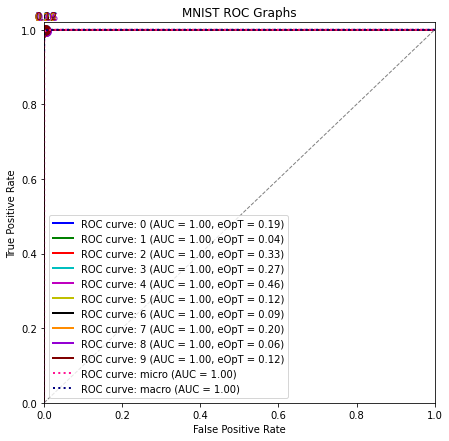

In [9]:
with tf.Session() as sess:
    saver.restore(sess, filename)
    y_pred = sess.run(output, feed_dict={x: mnist.test.images, keep_prob: 1.})
    acc = 100 * np.sum(np.equal(y_true, np.argmax(y_pred, axis=1))) / len(y_true)
    print(f'--------\nBest accuracy: {acc:.1f}%')
    roc_graph(y_true=mnist.test.labels, y_pred=y_pred,
              filename='roc_graph.png', title='MNIST ROC Graphs',
              colors=_ROC_PLOT_COLORS + ['darkviolet', 'maroon'],
              figsize=(7, 7))